In [1]:
import numpy as np
import pandas as pd 
import scipy as sp
import scipy.io
from scipy.stats import norm
from scipy.stats import multivariate_normal
from scipy.signal import find_peaks, peak_widths

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import os
import glob
import fnmatch
import re
import argparse

import sys, getopt

from AnalysisUtils import *

In [2]:
path = './calib15june-ch2_0-400files_prominence2000.npy'
data = np.load(path, allow_pickle=True)


In [3]:
df_raw = pd.DataFrame(data)
df_raw.head()

,0,1,2,3,4,5,6,7,8,9,...,100003,100004,100005,100006,100007,100008,100009,100010,100011,100012
0,e,/pro,2020-06-15 11:35:05.950432224,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4352,4352,False,4304.79,0,0,0,0,False,False
1,e,/pro,2020-06-15 11:35:05.983038603,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3328,3584,False,4422.24,1,3735.55,1071.58,2.82775e+06,True,True
2,e,/pro,2020-06-15 11:35:05.470000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3840,3840,False,4216.67,1,4625.41,1082.59,3.70533e+06,True,True
3,e,/pro,2020-06-15 11:35:05.503000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2816,3328,False,4184.12,1,3371.01,1136.71,2.69852e+06,True,True
4,e,/pro,2020-06-15 11:35:05.535000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2816,3328,False,4076.45,1,3910.66,1097.2,3.05453e+06,True,True


In [4]:
dropcol = list(range(100005, 100013))  # to cleanup from previous spe calculation and re-dothem
dropcol
df_raw.drop(dropcol, axis=1, inplace =True)
df_raw.head()

,0,1,2,3,4,5,6,7,8,9,...,99995,99996,99997,99998,99999,100000,100001,100002,100003,100004
0,e,/pro,2020-06-15 11:35:05.950432224,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4608,4864,4096,4608,5376,5376,4864,4864,4352,4352
1,e,/pro,2020-06-15 11:35:05.983038603,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3328,3840,4608,4096,4352,4096,4352,4096,3328,3584
2,e,/pro,2020-06-15 11:35:05.470000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3584,4096,4096,4096,3584,3840,3584,3840,3840,3840
3,e,/pro,2020-06-15 11:35:05.503000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4864,4096,3840,3072,3328,2816,2816,2048,2816,3328
4,e,/pro,2020-06-15 11:35:05.535000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3840,3840,3840,3840,3328,3584,3072,3072,2816,3328


In [5]:
df = compute_singlepe(df_raw)
df = select_singlepe(df)
df.head(20)

,0,1,2,3,4,5,6,7,8,9,...,100001,100002,100003,100004,n pe,pe height,pe width,pe area,spe 1sig,spe 2sig
0,e,/pro,2020-06-15 11:35:05.950432224,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4864,4864,4352,4352,0.0,0.000,0.000000,0.000000e+00,False,False
1,e,/pro,2020-06-15 11:35:05.983038603,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4352,4096,3328,3584,1.0,3735.552,1609.430000,3.153752e+06,True,True
2,e,/pro,2020-06-15 11:35:05.470000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3584,3840,3840,3840,1.0,4625.408,1790.854167,4.612667e+06,False,True
3,e,/pro,2020-06-15 11:35:05.503000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2816,2048,2816,3328,1.0,3371.008,1667.490476,3.165302e+06,True,True
4,e,/pro,2020-06-15 11:35:05.535000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3072,3072,2816,3328,1.0,3910.656,1454.637727,3.396144e+06,True,True


In [7]:
def plot_contours(X, mean, cov, stepx1, stepx2):
    
    X1range = np.arange(np.min(X[:,0]),np.max(X[:,0]),stepx1)
    X2range = np.arange(np.min(X[:,1]),np.max(X[:,1]),stepx2)

    X1mesh, X2mesh = np.meshgrid(X1range, X2range)
    
    coord_list = [ np.array([X0,X1]) for X0, X1 in zip(np.ravel(X1mesh), np.ravel(X2mesh)) ]
    Z = multivariate_normal.pdf( coord_list , mean=mean, cov=cov)
    Z = Z.reshape(X1mesh.shape)
    
    #cont_levels = [10**exp for exp in range(-50,0,3)]
    sigma = np.sqrt(np.diag(cov))
    nsigma = np.array([mean+n*sigma for n in range(1,3)[::-1]])
    
    cont_levels = multivariate_normal.pdf( nsigma , mean=mean, cov=cov)    
    cs = plt.contour(X1mesh, X2mesh, Z, 10, levels=cont_levels, colors=('blue', 'yellow', 'orange', 'red' ))
   
    #plt.clabel(cs, fmt='%g', inline=1, fontsize=10)

    fmt = {}
    strs = ['$1 \sigma$', '$2 \sigma$', '$3 \sigma$']
    for l, s in zip(cs.levels[::-1], strs):
        fmt[l] = s

    # Label every other level using strings
    plt.clabel(cs, cs.levels, inline=True, fmt=fmt, fontsize=18)

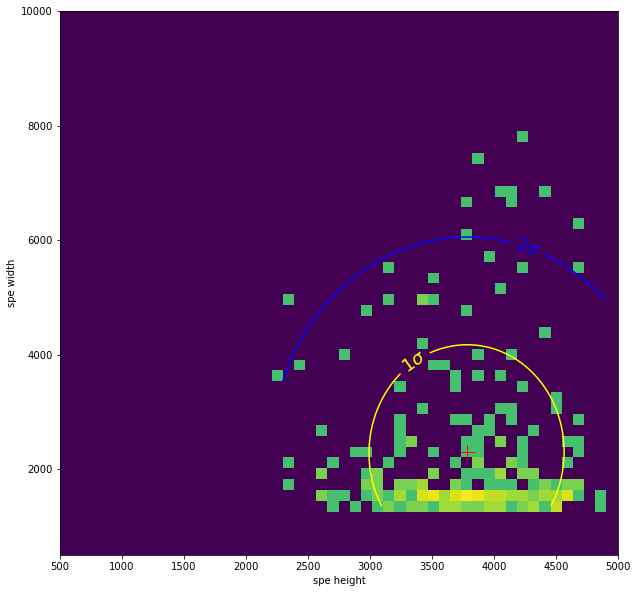

In [8]:
X_pe=df.loc[(df['pe height']>0)& (df['pe width']>0),['pe height', 'pe width']].values
mu, cov = estimate_gaus_param(X_pe,True)


plt.figure(figsize=(10,10))

plt.plot(mu[0], mu[1], marker='+', ms=15, c='red')

plt.hist2d( X_pe[:,0] , X_pe[:,1], 
           [50,50],
           range=[[500,5000],[500, 10000]],
           cmap='viridis',
           norm=mcolors.PowerNorm(0.18))


plt.xlabel('spe height')
plt.ylabel('spe width')


plot_contours(X_pe, mu, cov, 5, 50)
plt.show()

In [9]:
def do_average_singlepe_new(df):
    df = df.copy()
    
    area = df.loc[(df['spe 1sig']==True) ]['pe area'].mean()
    std  = df.loc[(df['spe 1sig']==True) ]['pe area'].std()
        
    #df_tmp=pd.merge(left = area, right=std, on=['Run number', 'Ch'],suffixes = ('_mean', '_std') )
    #df_av_spe.append(df_tmp)

    return area, std


In [15]:
sel_spe_area, sel_spe_std = do_average_singlepe_new(df)
print('mean spe area :', sel_spe_area)
print('mean spe std  :', sel_spe_std)


mean spe area : 3911418.558653868
mean spe std  : 1001015.2087642121


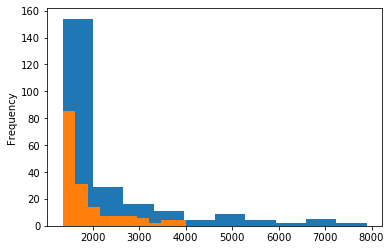

In [11]:
df.loc[(df['pe height']>0)]['pe width'].plot(kind='hist', label="all spe")
df.loc[(df['pe height']>0) & (df['spe 1sig']==True)]['pe width'].plot(kind='hist', label="selected spe")


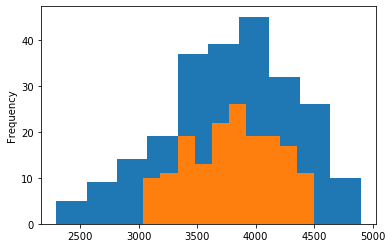

In [14]:
df.loc[(df['pe height']>0)]['pe height'].plot(kind='hist', label="full width")
df.loc[(df['pe height']>0) & (df['spe 1sig']==True)]['pe height'].plot(kind='hist', label="selected spe")


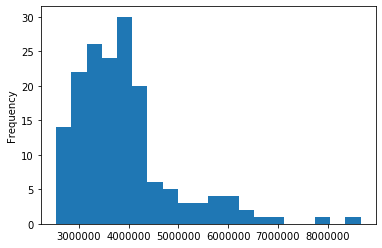

In [22]:
df.loc[(df['pe height']>0) & (df['spe 1sig']==True)]['pe area'].plot(kind='hist', label="selected spe", bins=20)
